# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

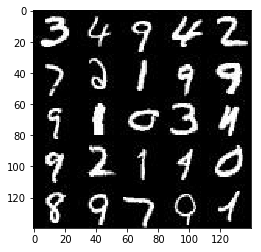

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

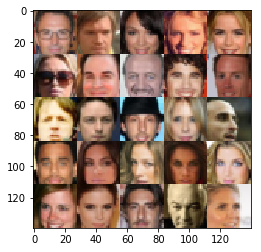

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    image_input = tf.placeholder(tf.float32, [None, image_width, image_height, image_channels])
    input_z = tf.placeholder(tf.float32, [None, z_dim])
    lr = tf.placeholder(tf.float32, name="learning_rate")

    return image_input, input_z, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [8]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    with tf.variable_scope('discriminator', reuse=reuse):
        alpha = 0.1
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
   
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)

        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [9]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    with tf.variable_scope('generator', reuse=not is_train):
        alpha = 0.1
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)

        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)

        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=1, padding='same')
        
        out = tf.tanh(logits)
    return out

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [10]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    smooth = 0.1
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, 
                                                                         labels=tf.ones_like(d_model_real)* 
                                                                         (1 - smooth)))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                                         labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                                                    labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [11]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    gen_updates = [op for op in update_ops if op.name.startswith('generator')]
    # Optimize

    with tf.control_dependencies(gen_updates):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt
    


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [12]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [13]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    _ , image_width, image_height, image_channels = data_shape
    image_input, z_input, lr = model_inputs(image_width, image_height, image_channels, z_dim)
    
    d_loss, g_loss = model_loss(image_input, z_input, len(data_image_mode))
    
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        steps = 0
        for epoch_i in range(epoch_count):
            
            for batch_images in get_batches(batch_size):
                batch_images *= 2
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_train_opt, feed_dict={image_input: batch_images, z_input: batch_z, lr:learning_rate})
                _ = sess.run(g_train_opt, feed_dict={z_input: batch_z, lr:learning_rate})
                _ = sess.run(g_train_opt, feed_dict={z_input: batch_z, lr:learning_rate})
                steps +=1
                if steps % 10 == 0:
                    train_loss_d = d_loss.eval({z_input: batch_z, image_input: batch_images})
                    train_loss_g = g_loss.eval({z_input: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                if steps % 100 == 0:
                    show_generator_output(sess, 25, z_input, image_channels, data_image_mode)
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.5557... Generator Loss: 2.1306
Epoch 1/2... Discriminator Loss: 2.6677... Generator Loss: 1.4990
Epoch 1/2... Discriminator Loss: 1.9663... Generator Loss: 0.4334
Epoch 1/2... Discriminator Loss: 2.0933... Generator Loss: 0.4214
Epoch 1/2... Discriminator Loss: 1.8474... Generator Loss: 0.5139
Epoch 1/2... Discriminator Loss: 1.9897... Generator Loss: 0.3844
Epoch 1/2... Discriminator Loss: 1.7515... Generator Loss: 0.7866
Epoch 1/2... Discriminator Loss: 1.7728... Generator Loss: 0.6299
Epoch 1/2... Discriminator Loss: 1.7012... Generator Loss: 0.9730
Epoch 1/2... Discriminator Loss: 1.5218... Generator Loss: 0.7826


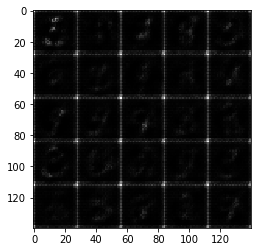

Epoch 1/2... Discriminator Loss: 1.4956... Generator Loss: 0.7663
Epoch 1/2... Discriminator Loss: 1.4530... Generator Loss: 0.9367
Epoch 1/2... Discriminator Loss: 1.4625... Generator Loss: 0.6080
Epoch 1/2... Discriminator Loss: 1.3748... Generator Loss: 0.6232
Epoch 1/2... Discriminator Loss: 1.4203... Generator Loss: 1.0177
Epoch 1/2... Discriminator Loss: 1.4105... Generator Loss: 0.6465
Epoch 1/2... Discriminator Loss: 1.4592... Generator Loss: 1.0213
Epoch 1/2... Discriminator Loss: 1.5492... Generator Loss: 0.4396
Epoch 1/2... Discriminator Loss: 1.4225... Generator Loss: 0.6011
Epoch 1/2... Discriminator Loss: 1.5250... Generator Loss: 1.1417


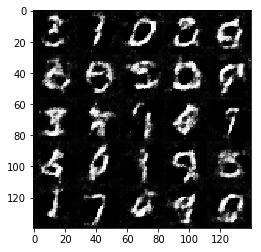

Epoch 1/2... Discriminator Loss: 1.5389... Generator Loss: 0.4936
Epoch 1/2... Discriminator Loss: 1.4682... Generator Loss: 0.6851
Epoch 1/2... Discriminator Loss: 1.4357... Generator Loss: 0.5256
Epoch 1/2... Discriminator Loss: 1.4785... Generator Loss: 0.6248
Epoch 1/2... Discriminator Loss: 1.3590... Generator Loss: 0.7056
Epoch 1/2... Discriminator Loss: 1.4433... Generator Loss: 0.8463
Epoch 1/2... Discriminator Loss: 1.6562... Generator Loss: 1.3788
Epoch 1/2... Discriminator Loss: 1.4975... Generator Loss: 0.5239
Epoch 1/2... Discriminator Loss: 1.5804... Generator Loss: 0.4356
Epoch 1/2... Discriminator Loss: 1.5254... Generator Loss: 0.4849


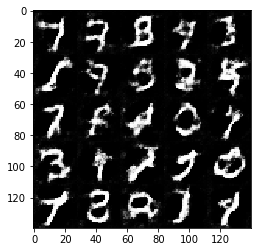

Epoch 1/2... Discriminator Loss: 1.5725... Generator Loss: 0.4655
Epoch 1/2... Discriminator Loss: 1.3957... Generator Loss: 0.6711
Epoch 1/2... Discriminator Loss: 1.4432... Generator Loss: 0.6802
Epoch 1/2... Discriminator Loss: 1.5405... Generator Loss: 1.0442
Epoch 1/2... Discriminator Loss: 1.4287... Generator Loss: 0.6668
Epoch 1/2... Discriminator Loss: 1.5424... Generator Loss: 0.4925
Epoch 1/2... Discriminator Loss: 1.4827... Generator Loss: 0.8401
Epoch 1/2... Discriminator Loss: 1.4455... Generator Loss: 1.0412
Epoch 1/2... Discriminator Loss: 1.4093... Generator Loss: 0.6477
Epoch 1/2... Discriminator Loss: 1.5894... Generator Loss: 0.4042


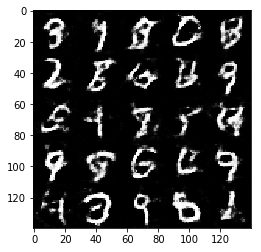

Epoch 1/2... Discriminator Loss: 1.3915... Generator Loss: 0.7418
Epoch 1/2... Discriminator Loss: 1.4847... Generator Loss: 0.5601
Epoch 1/2... Discriminator Loss: 1.4398... Generator Loss: 0.7281
Epoch 1/2... Discriminator Loss: 1.4239... Generator Loss: 0.5871
Epoch 1/2... Discriminator Loss: 1.6767... Generator Loss: 0.3404
Epoch 1/2... Discriminator Loss: 1.4258... Generator Loss: 0.8061
Epoch 2/2... Discriminator Loss: 1.3881... Generator Loss: 0.8273
Epoch 2/2... Discriminator Loss: 1.4446... Generator Loss: 0.8909
Epoch 2/2... Discriminator Loss: 1.4110... Generator Loss: 0.9989
Epoch 2/2... Discriminator Loss: 1.4832... Generator Loss: 0.7969


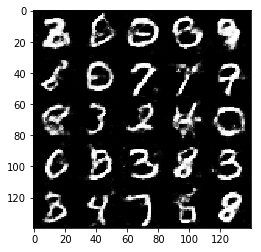

Epoch 2/2... Discriminator Loss: 1.6475... Generator Loss: 0.3867
Epoch 2/2... Discriminator Loss: 1.5092... Generator Loss: 0.9600
Epoch 2/2... Discriminator Loss: 1.4259... Generator Loss: 0.7374
Epoch 2/2... Discriminator Loss: 1.3910... Generator Loss: 0.7626
Epoch 2/2... Discriminator Loss: 1.5196... Generator Loss: 0.5103
Epoch 2/2... Discriminator Loss: 1.4127... Generator Loss: 0.7372
Epoch 2/2... Discriminator Loss: 1.4796... Generator Loss: 0.7917
Epoch 2/2... Discriminator Loss: 1.4403... Generator Loss: 0.7695
Epoch 2/2... Discriminator Loss: 1.5829... Generator Loss: 0.4311
Epoch 2/2... Discriminator Loss: 1.4816... Generator Loss: 0.5193


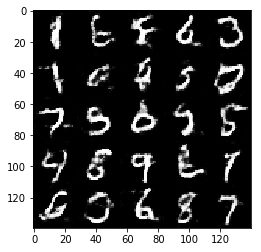

Epoch 2/2... Discriminator Loss: 1.6627... Generator Loss: 0.3533
Epoch 2/2... Discriminator Loss: 1.4480... Generator Loss: 1.0175
Epoch 2/2... Discriminator Loss: 1.4756... Generator Loss: 1.1558
Epoch 2/2... Discriminator Loss: 1.4152... Generator Loss: 0.7121
Epoch 2/2... Discriminator Loss: 1.7305... Generator Loss: 0.3298
Epoch 2/2... Discriminator Loss: 1.4742... Generator Loss: 0.5065
Epoch 2/2... Discriminator Loss: 1.3875... Generator Loss: 0.7264
Epoch 2/2... Discriminator Loss: 1.4329... Generator Loss: 0.6692
Epoch 2/2... Discriminator Loss: 1.5090... Generator Loss: 0.5279
Epoch 2/2... Discriminator Loss: 1.4455... Generator Loss: 0.5528


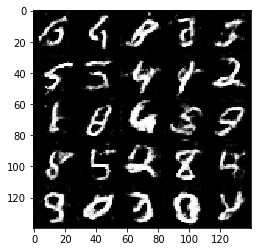

Epoch 2/2... Discriminator Loss: 1.4887... Generator Loss: 0.5333
Epoch 2/2... Discriminator Loss: 1.5646... Generator Loss: 0.4389
Epoch 2/2... Discriminator Loss: 1.4503... Generator Loss: 0.9447
Epoch 2/2... Discriminator Loss: 1.4860... Generator Loss: 0.5613
Epoch 2/2... Discriminator Loss: 1.4494... Generator Loss: 0.7173
Epoch 2/2... Discriminator Loss: 1.3596... Generator Loss: 0.8374
Epoch 2/2... Discriminator Loss: 1.4122... Generator Loss: 0.7607
Epoch 2/2... Discriminator Loss: 1.4088... Generator Loss: 0.9210
Epoch 2/2... Discriminator Loss: 1.4713... Generator Loss: 1.1521
Epoch 2/2... Discriminator Loss: 1.5533... Generator Loss: 0.4807


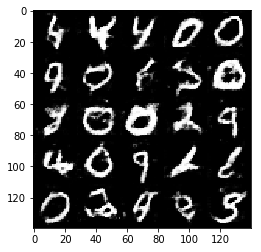

Epoch 2/2... Discriminator Loss: 1.4177... Generator Loss: 0.7156
Epoch 2/2... Discriminator Loss: 1.5988... Generator Loss: 1.4621
Epoch 2/2... Discriminator Loss: 1.4375... Generator Loss: 0.6120
Epoch 2/2... Discriminator Loss: 1.4516... Generator Loss: 0.5702
Epoch 2/2... Discriminator Loss: 1.3732... Generator Loss: 0.7969
Epoch 2/2... Discriminator Loss: 1.3721... Generator Loss: 0.8849
Epoch 2/2... Discriminator Loss: 1.5178... Generator Loss: 0.5057
Epoch 2/2... Discriminator Loss: 1.4681... Generator Loss: 0.5589
Epoch 2/2... Discriminator Loss: 1.4267... Generator Loss: 0.6187
Epoch 2/2... Discriminator Loss: 1.7135... Generator Loss: 0.3469


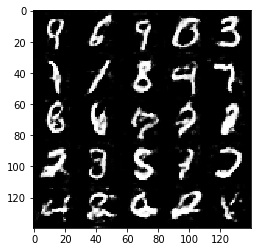

Epoch 2/2... Discriminator Loss: 1.3372... Generator Loss: 0.8426
Epoch 2/2... Discriminator Loss: 1.4256... Generator Loss: 0.5718
Epoch 2/2... Discriminator Loss: 1.8157... Generator Loss: 0.3102


In [14]:
batch_size = 128
z_dim = 128
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 2.1898... Generator Loss: 0.3650
Epoch 1/1... Discriminator Loss: 2.4785... Generator Loss: 0.3584
Epoch 1/1... Discriminator Loss: 2.7522... Generator Loss: 0.2110
Epoch 1/1... Discriminator Loss: 1.9544... Generator Loss: 0.6232
Epoch 1/1... Discriminator Loss: 1.9362... Generator Loss: 0.4849
Epoch 1/1... Discriminator Loss: 1.8659... Generator Loss: 0.5145
Epoch 1/1... Discriminator Loss: 1.7460... Generator Loss: 0.6809
Epoch 1/1... Discriminator Loss: 1.5140... Generator Loss: 0.9126
Epoch 1/1... Discriminator Loss: 1.8008... Generator Loss: 0.5554
Epoch 1/1... Discriminator Loss: 1.9396... Generator Loss: 0.5268


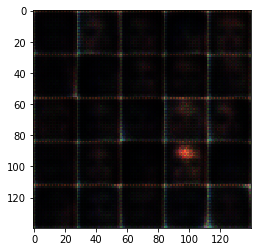

Epoch 1/1... Discriminator Loss: 1.6919... Generator Loss: 0.6285
Epoch 1/1... Discriminator Loss: 1.6938... Generator Loss: 0.6194
Epoch 1/1... Discriminator Loss: 1.6524... Generator Loss: 0.5835
Epoch 1/1... Discriminator Loss: 1.6336... Generator Loss: 0.6255
Epoch 1/1... Discriminator Loss: 1.6542... Generator Loss: 0.6101
Epoch 1/1... Discriminator Loss: 1.6243... Generator Loss: 0.6090
Epoch 1/1... Discriminator Loss: 1.7142... Generator Loss: 0.6139
Epoch 1/1... Discriminator Loss: 1.5015... Generator Loss: 0.8226
Epoch 1/1... Discriminator Loss: 1.5517... Generator Loss: 0.7321
Epoch 1/1... Discriminator Loss: 1.6691... Generator Loss: 0.6495


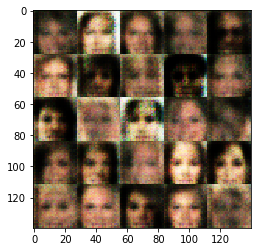

Epoch 1/1... Discriminator Loss: 1.5442... Generator Loss: 0.7128
Epoch 1/1... Discriminator Loss: 1.6451... Generator Loss: 0.6604
Epoch 1/1... Discriminator Loss: 1.5652... Generator Loss: 0.7752
Epoch 1/1... Discriminator Loss: 1.4740... Generator Loss: 0.7138
Epoch 1/1... Discriminator Loss: 1.5126... Generator Loss: 0.7077
Epoch 1/1... Discriminator Loss: 1.5613... Generator Loss: 0.6759
Epoch 1/1... Discriminator Loss: 1.6566... Generator Loss: 0.6386
Epoch 1/1... Discriminator Loss: 1.5495... Generator Loss: 0.6293
Epoch 1/1... Discriminator Loss: 1.4557... Generator Loss: 0.7018
Epoch 1/1... Discriminator Loss: 1.6322... Generator Loss: 0.6829


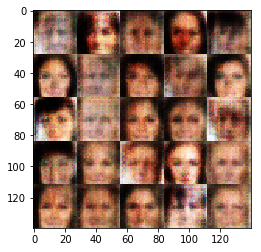

Epoch 1/1... Discriminator Loss: 1.5371... Generator Loss: 0.6851
Epoch 1/1... Discriminator Loss: 1.4602... Generator Loss: 0.7482
Epoch 1/1... Discriminator Loss: 1.4824... Generator Loss: 0.7218
Epoch 1/1... Discriminator Loss: 1.5323... Generator Loss: 0.6981
Epoch 1/1... Discriminator Loss: 1.4683... Generator Loss: 0.7456
Epoch 1/1... Discriminator Loss: 1.5398... Generator Loss: 0.7183
Epoch 1/1... Discriminator Loss: 1.4978... Generator Loss: 0.7125
Epoch 1/1... Discriminator Loss: 1.4595... Generator Loss: 0.7282
Epoch 1/1... Discriminator Loss: 1.5305... Generator Loss: 0.7084
Epoch 1/1... Discriminator Loss: 1.5260... Generator Loss: 0.6877


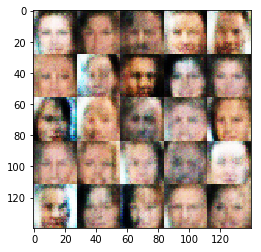

Epoch 1/1... Discriminator Loss: 1.4405... Generator Loss: 0.7191
Epoch 1/1... Discriminator Loss: 1.5222... Generator Loss: 0.6803
Epoch 1/1... Discriminator Loss: 1.5246... Generator Loss: 0.7396
Epoch 1/1... Discriminator Loss: 1.4755... Generator Loss: 0.7344
Epoch 1/1... Discriminator Loss: 1.5507... Generator Loss: 0.6995
Epoch 1/1... Discriminator Loss: 1.5229... Generator Loss: 0.6827
Epoch 1/1... Discriminator Loss: 1.4870... Generator Loss: 0.7031
Epoch 1/1... Discriminator Loss: 1.4819... Generator Loss: 0.7076
Epoch 1/1... Discriminator Loss: 1.4308... Generator Loss: 0.7489
Epoch 1/1... Discriminator Loss: 1.5441... Generator Loss: 0.7222


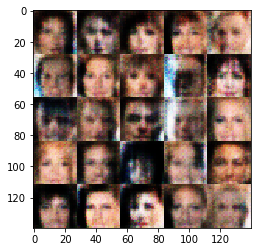

Epoch 1/1... Discriminator Loss: 1.4901... Generator Loss: 0.7118
Epoch 1/1... Discriminator Loss: 1.5076... Generator Loss: 0.7305
Epoch 1/1... Discriminator Loss: 1.3964... Generator Loss: 0.8198
Epoch 1/1... Discriminator Loss: 1.4574... Generator Loss: 0.7760
Epoch 1/1... Discriminator Loss: 1.4433... Generator Loss: 0.7602
Epoch 1/1... Discriminator Loss: 1.4226... Generator Loss: 0.7878
Epoch 1/1... Discriminator Loss: 1.4462... Generator Loss: 0.7761
Epoch 1/1... Discriminator Loss: 1.4549... Generator Loss: 0.7917
Epoch 1/1... Discriminator Loss: 1.4489... Generator Loss: 0.7155
Epoch 1/1... Discriminator Loss: 1.4523... Generator Loss: 0.7520


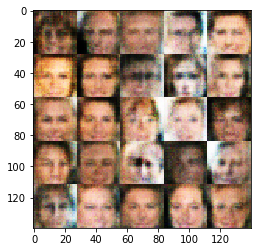

Epoch 1/1... Discriminator Loss: 1.4566... Generator Loss: 0.7800
Epoch 1/1... Discriminator Loss: 1.4860... Generator Loss: 0.7755
Epoch 1/1... Discriminator Loss: 1.4020... Generator Loss: 0.7511
Epoch 1/1... Discriminator Loss: 1.4801... Generator Loss: 0.7495
Epoch 1/1... Discriminator Loss: 1.4379... Generator Loss: 0.7064
Epoch 1/1... Discriminator Loss: 1.4725... Generator Loss: 0.7261
Epoch 1/1... Discriminator Loss: 1.4494... Generator Loss: 0.7520
Epoch 1/1... Discriminator Loss: 1.4539... Generator Loss: 0.7859
Epoch 1/1... Discriminator Loss: 1.4629... Generator Loss: 0.8068
Epoch 1/1... Discriminator Loss: 1.4006... Generator Loss: 0.7803


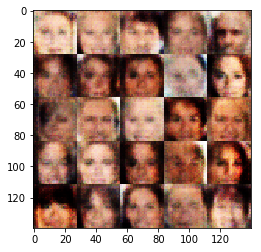

Epoch 1/1... Discriminator Loss: 1.4611... Generator Loss: 0.7715
Epoch 1/1... Discriminator Loss: 1.4975... Generator Loss: 0.7480
Epoch 1/1... Discriminator Loss: 1.4315... Generator Loss: 0.7600
Epoch 1/1... Discriminator Loss: 1.4711... Generator Loss: 0.7481
Epoch 1/1... Discriminator Loss: 1.4472... Generator Loss: 0.7353
Epoch 1/1... Discriminator Loss: 1.4458... Generator Loss: 0.7475
Epoch 1/1... Discriminator Loss: 1.4378... Generator Loss: 0.7173
Epoch 1/1... Discriminator Loss: 1.4170... Generator Loss: 0.7885
Epoch 1/1... Discriminator Loss: 1.4246... Generator Loss: 0.7842
Epoch 1/1... Discriminator Loss: 1.4150... Generator Loss: 0.7931


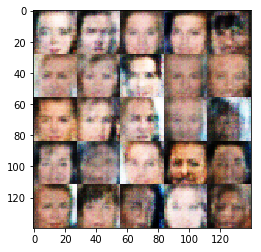

Epoch 1/1... Discriminator Loss: 1.4404... Generator Loss: 0.7671
Epoch 1/1... Discriminator Loss: 1.4403... Generator Loss: 0.7658
Epoch 1/1... Discriminator Loss: 1.4674... Generator Loss: 0.7219
Epoch 1/1... Discriminator Loss: 1.4861... Generator Loss: 0.7153
Epoch 1/1... Discriminator Loss: 1.4347... Generator Loss: 0.7441
Epoch 1/1... Discriminator Loss: 1.4213... Generator Loss: 0.7366
Epoch 1/1... Discriminator Loss: 1.4576... Generator Loss: 0.7317
Epoch 1/1... Discriminator Loss: 1.4607... Generator Loss: 0.7680
Epoch 1/1... Discriminator Loss: 1.4115... Generator Loss: 0.7579
Epoch 1/1... Discriminator Loss: 1.4526... Generator Loss: 0.7971


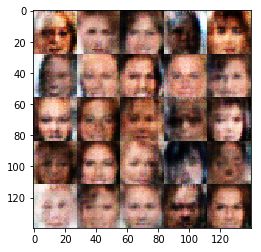

Epoch 1/1... Discriminator Loss: 1.4034... Generator Loss: 0.7494
Epoch 1/1... Discriminator Loss: 1.4286... Generator Loss: 0.7882
Epoch 1/1... Discriminator Loss: 1.4159... Generator Loss: 0.7612
Epoch 1/1... Discriminator Loss: 1.4561... Generator Loss: 0.7467
Epoch 1/1... Discriminator Loss: 1.4188... Generator Loss: 0.7353
Epoch 1/1... Discriminator Loss: 1.4319... Generator Loss: 0.7363
Epoch 1/1... Discriminator Loss: 1.4284... Generator Loss: 0.7375
Epoch 1/1... Discriminator Loss: 1.3980... Generator Loss: 0.7568
Epoch 1/1... Discriminator Loss: 1.4445... Generator Loss: 0.7251
Epoch 1/1... Discriminator Loss: 1.4153... Generator Loss: 0.7761


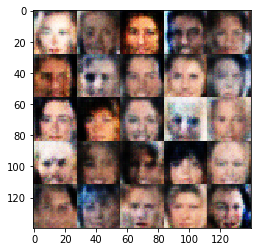

Epoch 1/1... Discriminator Loss: 1.4223... Generator Loss: 0.7643
Epoch 1/1... Discriminator Loss: 1.4151... Generator Loss: 0.7750
Epoch 1/1... Discriminator Loss: 1.4307... Generator Loss: 0.8198
Epoch 1/1... Discriminator Loss: 1.4469... Generator Loss: 0.7737
Epoch 1/1... Discriminator Loss: 1.4459... Generator Loss: 0.7573
Epoch 1/1... Discriminator Loss: 1.4221... Generator Loss: 0.7784
Epoch 1/1... Discriminator Loss: 1.4420... Generator Loss: 0.7525
Epoch 1/1... Discriminator Loss: 1.4129... Generator Loss: 0.7915
Epoch 1/1... Discriminator Loss: 1.3531... Generator Loss: 0.8637
Epoch 1/1... Discriminator Loss: 1.4149... Generator Loss: 0.7527


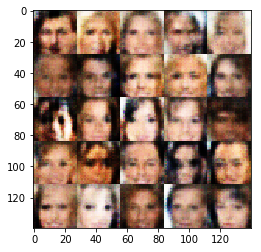

Epoch 1/1... Discriminator Loss: 1.3931... Generator Loss: 0.7891
Epoch 1/1... Discriminator Loss: 1.4178... Generator Loss: 0.7815
Epoch 1/1... Discriminator Loss: 1.4139... Generator Loss: 0.7678
Epoch 1/1... Discriminator Loss: 1.3779... Generator Loss: 0.8341
Epoch 1/1... Discriminator Loss: 1.4302... Generator Loss: 0.7705
Epoch 1/1... Discriminator Loss: 1.4137... Generator Loss: 0.7453
Epoch 1/1... Discriminator Loss: 1.4188... Generator Loss: 0.8095
Epoch 1/1... Discriminator Loss: 1.3891... Generator Loss: 0.7947
Epoch 1/1... Discriminator Loss: 1.4337... Generator Loss: 0.7594
Epoch 1/1... Discriminator Loss: 1.4243... Generator Loss: 0.7388


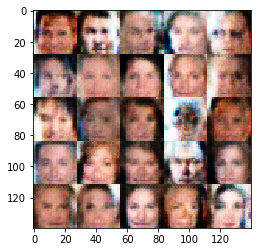

Epoch 1/1... Discriminator Loss: 1.3775... Generator Loss: 0.7983
Epoch 1/1... Discriminator Loss: 1.3734... Generator Loss: 0.7951
Epoch 1/1... Discriminator Loss: 1.4191... Generator Loss: 0.7195
Epoch 1/1... Discriminator Loss: 1.3467... Generator Loss: 0.8741
Epoch 1/1... Discriminator Loss: 1.1080... Generator Loss: 1.2137
Epoch 1/1... Discriminator Loss: 1.2994... Generator Loss: 0.5932
Epoch 1/1... Discriminator Loss: 1.2559... Generator Loss: 0.8646
Epoch 1/1... Discriminator Loss: 1.4242... Generator Loss: 0.5681
Epoch 1/1... Discriminator Loss: 1.3558... Generator Loss: 1.0222
Epoch 1/1... Discriminator Loss: 1.4368... Generator Loss: 0.9107


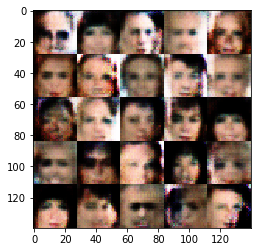

Epoch 1/1... Discriminator Loss: 1.2549... Generator Loss: 1.0774
Epoch 1/1... Discriminator Loss: 1.4501... Generator Loss: 0.7385
Epoch 1/1... Discriminator Loss: 1.5694... Generator Loss: 0.7467
Epoch 1/1... Discriminator Loss: 1.4527... Generator Loss: 0.8296
Epoch 1/1... Discriminator Loss: 1.5793... Generator Loss: 0.6909
Epoch 1/1... Discriminator Loss: 1.5475... Generator Loss: 0.6668
Epoch 1/1... Discriminator Loss: 1.5188... Generator Loss: 0.6649
Epoch 1/1... Discriminator Loss: 1.4743... Generator Loss: 0.6347
Epoch 1/1... Discriminator Loss: 1.4222... Generator Loss: 0.8499
Epoch 1/1... Discriminator Loss: 1.4567... Generator Loss: 0.7422


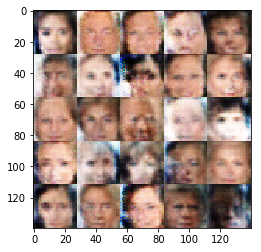

Epoch 1/1... Discriminator Loss: 1.3633... Generator Loss: 0.8000
Epoch 1/1... Discriminator Loss: 1.4979... Generator Loss: 0.7024
Epoch 1/1... Discriminator Loss: 1.4283... Generator Loss: 0.7451
Epoch 1/1... Discriminator Loss: 1.4377... Generator Loss: 0.7367
Epoch 1/1... Discriminator Loss: 1.4822... Generator Loss: 0.7168
Epoch 1/1... Discriminator Loss: 1.4608... Generator Loss: 0.7184
Epoch 1/1... Discriminator Loss: 1.4711... Generator Loss: 0.7742
Epoch 1/1... Discriminator Loss: 1.4696... Generator Loss: 0.7617
Epoch 1/1... Discriminator Loss: 1.4328... Generator Loss: 0.7811
Epoch 1/1... Discriminator Loss: 1.4458... Generator Loss: 0.7219


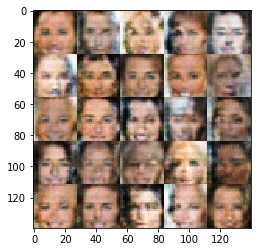

Epoch 1/1... Discriminator Loss: 1.4319... Generator Loss: 0.7875
Epoch 1/1... Discriminator Loss: 1.4126... Generator Loss: 0.7765
Epoch 1/1... Discriminator Loss: 1.4011... Generator Loss: 0.8003
Epoch 1/1... Discriminator Loss: 1.4440... Generator Loss: 0.7886
Epoch 1/1... Discriminator Loss: 1.4013... Generator Loss: 0.7698
Epoch 1/1... Discriminator Loss: 1.4310... Generator Loss: 0.7538
Epoch 1/1... Discriminator Loss: 1.4050... Generator Loss: 0.7378
Epoch 1/1... Discriminator Loss: 1.4226... Generator Loss: 0.7289


In [15]:
batch_size = 128
z_dim = 128
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.